In [69]:
from queue import PriorityQueue
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import copy
import time
import random

In [7]:
#-----------------------------------------------------PUZZLE MAKING FUNCTIONS-----------------------------------------------------


#Generate solved puzzle of given size
def solved(size):
    #Make puzzle
    puzzle = []
    for r in range(size):
        #make rowS
        row = []
        for c in range(size):
            #insert tile into row
            row.append((r*size)+c+1)
        #insert row into puzzle
        puzzle.append(row)
    #make sure to include empty position
    puzzle[size-1][size-1] = 0
    return puzzle


#allow user to enter puzzle state of given size
def user(size):
    #make puzzle
    puzzle = []
    for r in range(size):
        #make row
        row = []
        for c in range(size):
            #get user input and insert tile into row
            row.append(int(input(f"Tile at row {r} and column {c}:")))
        #insert row into puzzle
        puzzle.append(row)
    return puzzle


#allow for random puzzles to be created
def rand(size, depth):
    #start with solved state to guarantee all tiles are present
    r = solved(size)
    #randomize the number of moves to take
    numMoves = random.randint(0,depth)
    for move in range(numMoves):
        #get the children of the puzzle
        c = children(r)
        #pick a random child of the puzzle and replace the puzzle with it
        r = c[random.randint(0,len(c)-1)]
    return r


#execute move on puzzle
def move(puzzle, direction):
    zero = find(puzzle,0)
    #replace the empty tile with the tile in the given direction
    puzzle[zero[0]][zero[1]] = puzzle[zero[0]+direction[0]][zero[1]+direction[1]]
    #put an empty tile where the other tile used to be
    puzzle[zero[0]+direction[0]][zero[1]+direction[1]] = 0


#get all valid children of a puzzle
def children(puzzle):
    children = []
    #find the empty position of the puzzle
    zero = find(puzzle, 0)
    #iterate over all moves
    for move in [(1,0),(0,1),(-1,0),(0,-1)]:
        #check if the move goes out of the range of the puzzle
        if 0<=zero[0]+move[0]<len(puzzle) and 0<=zero[1]+move[1]<len(puzzle):
            #make sure to make a deep copy of the puzzle list
            child = copy.deepcopy(puzzle)
            #swap zero and neighbour
            child[zero[0]][zero[1]] = child[zero[0]+move[0]][zero[1]+move[1]]
            child[zero[0]+move[0]][zero[1]+move[1]] = 0
            #add child to list of children
            children.append(child)
    return children

In [8]:
#--------------------------------------------------------UTILITY FUNCTIONS--------------------------------------------------------


#calculate manhattan distance between two pairs
def manhattanDistance(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


#find given tile in puzzle and return pair (r,c)
def find(puzzle, tile):
    #iterate over rows
    for r in range(len(puzzle)):
        #iterate over columns
        for c in range(len(puzzle[r])):
            t = puzzle[r][c]
            #check for found tile
            if(t == tile):
                return (r,c)
    return (-1,-1)


#pad a given tile to a string of constant width based on puzzle size
def pad(size, tile):
    #calculate the largest tile and its length when converted to a string
    maxTile = size**2-1
    maxString = str(maxTile)
    maxLen = len(maxString)
    #convert the tile to a string
    tileString = str(tile)
    tileLen = len(tileString)
    #pad the tile string with spaces to make it the same length as the longest possible tile
    paddedString = " "*(maxLen-tileLen)+tileString
    return paddedString


#print a given puzzle in a nice way
def printPuzzle(puzzle):
    width = 0;
    #iterate over all rows
    for r in range(len(puzzle)):
        offsetString = " "*len(puzzle)
        rowString = "|".join(pad(len(puzzle),t) for t in puzzle[r])
        #print row string offset to the right
        print(offsetString+rowString)
        lineString = " "*len(offsetString)+"-"*len(rowString)
        #only print row delimeter if not the last row
        if r != puzzle[len(puzzle)-1]:
            print(lineString)
        width = 2*len(offsetString)+len(rowString)
    #end printing the puzzle with a line
    print("-"*width)


#print the path taken to a given path
def printPath(path):
    #print the puzzles in the order they occur in the path
    for puzzle in path:
        printPuzzle(puzzle)

In [9]:
#--------------------------------------------------------HEURISTIC FUNCTIONS------------------------------------------------------


#simply return 0
def uniformCostHeuristic(current, goal):
    return 0


#return the number of misplaced tiles between the two puzzles
def misplacedTileHeuristic(current, goal):
    #to start, no tiles are misplaced
    count = 0
    #iterate over all tiles
    for t in range(len(current)**2-1):
        #find tile in current puzzle
        c = find(current, t)
        #find tile in goal puzzle
        g = find(goal, t)
        #use boolean value coercement to 1 to add if mismatched
        count += c!=g
    return count


#return manhattan distance between two puzzles
def manhattanDistanceHeuristic(current, goal):
    #to start, distance is 0
    distance = 0
    for t in range(len(current)**2-1):
        #find tile in current puzzle
        c = find(current, t)
        #find tile in goal puzzle
        g = find(goal, t)
        #accumulate distance
        distance += manhattanDistance(c,g)
    return distance

In [19]:
#-------------------------------------------------------SEARCH FUNCTIONS-------------------------------------------------------


#general search function
def generalSearch(initial, goal, heuristic):
    #start timer
    start = round(time.time()*1000)
    #construct priority queue
    nodes = PriorityQueue()
    #construct list to keep track of visited states
    visited = []
    #insert inital state into queue with depth 0, priority 0, and path of itself
    nodes.put((0,[0,initial,[initial]]))
    while True:
        #return failure if no nodes left
        if nodes.empty():
            return "FAILURE"
        #get and remove top node
        node = nodes.get()
        depth = node[1][0]
        puzzle = node[1][1]
        path = node[1][2]
        visited.append(puzzle)
        #add node to visited
        #return node if puzzle is goal state
        if puzzle == goal:
            end = round(time.time()*1000)
            return (depth,path,len(visited),nodes.qsize(),end-start)
        #expand to all children
        for child in children(puzzle):
            #if the child is not visited, insert it into the queue to be visited
            if child not in visited:
                priority = depth+1+heuristic(child,goal)
                newdepth = depth+1
                newpath = copy.deepcopy(path)
                newpath.append(child)
                nodes.put((priority,[newdepth,child,newpath]))

In [70]:
#-------------------------------------------------TESTING AND DRIVER FUNCTIONS-------------------------------------------------


#all test cases from the project pdf with their index according to their depth
test = [
    [[1,2,3],[4,5,6],[7,8,0]],
    None,
    [[1,2,3],[4,5,6],[0,7,8]],
    None,
    [[1,2,3],[5,0,6],[4,7,8]],
    None,
    None,
    None,
    [[1,3,6],[5,0,2],[4,7,8]],
    None,
    None,
    None,
    [[1,3,6],[5,0,7],[4,8,2]],
    None,
    None,
    None,
    [[1,6,7],[5,0,3],[4,8,2]],
    None,
    None,
    None,
    [[7,1,2],[4,8,5],[6,3,0]],
    None,
    None,
    None,
    [[0,7,2],[4,6,1],[3,5,8]]
]


#run all test cases for a given heuristic
def testCases(heuristic):
    goal = solved(3)
    result = []
    #search for all puzzles in the test list
    for puzzle in test:
        if puzzle == None:
            result.append(None)
        else:
            result.append(generalSearch(puzzle,goal,heuristic)[0])
    for depth in range(len(result)):
        #if the depth is not what is expected, the search has failed
        if result[depth] != None:
            if depth == result[depth]:
                print(f"PASSED DEPTH {depth}")
            else:
                print(f"FAILED DEPTH {depth} - RESULT DEPTH AT {result[depth]}")

                

#function to run all tests on all heuristics
def testAll():
    if input("Are you sure you want to run these tests?") == "yes":
        print("TESTING MANHATTAN DISTANCE HEURISTIC")
        testCases(manhattanDistanceHeuristic)
        print("-"*25)
        print("TESTING MISPLACED TILE HEURISTIC")
        testCases(misplacedTileHeuristic)
        print("-"*25)
        print("TESTING UNIFORM COST HEURISTIC")
        testCases(uniformCostHeuristic)
        
        

#driver to run search algorithm generally
def driver():
    #get user input to decide what size
    print("What size puzzle would you like to solve?")
    size = int(input())
    if size < 1:
        print("INVALID SIZE SELECTION")
        return
    #get user puzzle or random puzzle
    print("Would you like to input a puzzle to solve or use a  random one?")
    print("\t1: user defined puzzle")
    print("\t2: random puzzle")
    option = int(input())
    if option == 1:
        initial = user(size)
    elif option == 2:
        initial = rand(size,100*size**2)
    else:
        print("INVALID PUZZLE CHOICE")
        return
    #allow user to select heuristic
    print("What heuristic would you like to use? Options are:")
    print("\t1: manhattanDistanceHeuristic")
    print("\t2: misplacedTileHeuristic")
    print("\t3: uniformCostHeuristic")
    option = int(input())
    if option == 1:
        heuristic = manhattanDistanceHeuristic
    elif option == 2:
        heuristic = misplacedTileHeuristic
    elif option == 3:
        heuristic = uniformCostHeuristic
    else:
        print("INVALID HEURISTIC INPUT")
        return
    #run search function and print solution (if there is one)
    solution = generalSearch(initial,solved(size),heuristic)
    if solution == "FAILURE":
        print("No solution found")
    else:
        print(f"Solution found at depth {solution[0]}")
        print(f"Visited {solution[2]} nodes")
        print(f"{solution[3]} nodes in the frontier")
        print(f"Search took {solution[4]} milliseconds")
        printPath(solution[1])


#monte carlo simulation to approximate visited states and frontier size per depth per heuristic
def monteCarlo(size, simulations, heuristic):
    goal = solved(size)
    depthDict = {}
    visitedDict = {}
    frontierDict = {}
    timeDict = {}
    for simulation in range(simulations):
        initial = rand(size,100*size**2)
        solution = generalSearch(initial,goal,heuristic)
        depth = solution[0]
        visited = solution[2]
        frontier = solution[3]
        time = solution[4]
        if depth not in depthDict:
            depthDict[depth] = 1
            visitedDict[depth] = visited
            frontierDict[depth] = frontier
            timeDict[depth] = time
        else:
            depthDict[depth] += 1
            visitedDict[depth] += visited
            frontierDict[depth] += frontier
            timeDict[depth] += time
    for depth in range(len(depthDict)-1):
        if depth in depthDict:
            visitedDict[depth] /= depthDict[depth]
            frontierDict[depth] /= depthDict[depth]
            timeDict[depth] /= depthDict[depth]
    return (visitedDict, frontierDict, timeDict)


#plot all monte carlo simulation results for given heuristic
def plotMC(visited, frontier, time):
    visitedList = sorted(visited.items())
    vx, vy = zip(*visitedList)
    visitedPlot = plt.plot(vx,vy, label = "Visited Nodes", color = "teal")
    frontierList = sorted(frontier.items())
    fx, fy = zip(*frontierList)
    frontierPlot = plt.plot(fx,fy, label = "Frontier Size", color = "firebrick")
    timeList = sorted(time.items())
    tx, ty = zip(*timeList)
    timePlot = plt.plot(tx,ty, label = "Search Time", color = "midnightblue")
    plt.gca().legend(loc = "upper left")
    plt.show()
    plt.setp(timePlot)

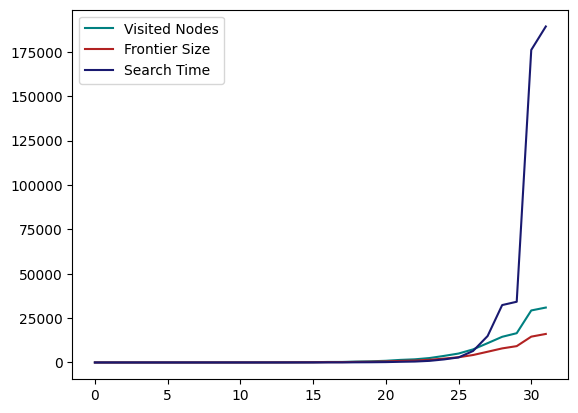

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

In [72]:
visited, frontier, t = monteCarlo(3,1000,manhattanDistanceHeuristic)
plotMC(visited, frontier, t)